# Imbalance Energy Market - Model Simulation

## Core Simulation Part

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from enum import Enum
from scipy.optimize import minimize
# from collections import OrderedDict
from functools import partial

/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [64]:
# --- 1) Parameters and initialisation ---
gamma = 9.0490
theta = 5.1768
sigma = 17.8482
rho = 0.85
Tmax = 1000

# ---1.1) AR(1) process ---
np.random.seed(12345)
eps = np.random.normal(0, sigma, (Tmax, 2))
print("sd(eps): ",(np.sum(eps**2)/(2*Tmax))**0.5)


sd(eps):  17.862437418805953


In [68]:
# --- Analytical Results for Immediate Pricing ---
alpha_1 = (rho*theta)/(theta+gamma)
beta_1 = (rho*gamma)/(theta+gamma)

alpha_3=theta*gamma *(rho/(theta + gamma))**2
beta_3=(rho * gamma / (theta + gamma))**2

print(f"alpha_1 = {alpha_1}")
print(f"beta_1  = {beta_1}")
print(f"alpha_2 = {alpha_1}")
print(f"beta_2  = {beta_1}")
print(f"alpha_3 = {alpha_3}")
print(f"beta_3  = {beta_3}")
print(f"alpha_4 = {alpha_3}")
print(f"beta_4  = {beta_3}")


alpha_1 = 0.3093168749736394
beta_1  = 0.5406831250263605
alpha_2 = 0.3093168749736394
beta_2  = 0.5406831250263605
alpha_3 = 0.16724241458413544
beta_3  = 0.292338241688271
alpha_4 = 0.16724241458413544
beta_4  = 0.292338241688271


In [72]:
# -- Analytical Result for Average Pricing ---

alpha_1 = rho * (2 * theta + 2 * gamma - gamma * (1 + rho)) / (2 * theta + 2 * gamma)
beta_1 = gamma * rho * (1 + rho) / (2 * theta + 2 * gamma)

alpha_2 = (2 * theta * rho - gamma) / (2 * theta + gamma)
beta_2 = gamma * (1 + rho) / (2 * theta + gamma)

alpha_3 = rho * gamma * (1 + rho) / (2 * theta + 2 * gamma + rho * gamma)
beta_3= gamma**2*rho*(rho + 1)**2/((gamma + 2*theta)*(gamma*rho + 2*gamma + 2*theta))

alpha_4 = (gamma * theta * rho ** 2 * (1 + rho)) / (2 * theta ** 2 + 3 * theta * gamma + gamma ** 2)
beta_4 = (gamma ** 2 * rho ** 2 * (1 + rho)) / (4 * theta ** 2 + 6 * theta * gamma + 2 * gamma ** 2)

beta_5= (rho * gamma / (theta + gamma))**2

print(f"alpha_1 = {alpha_1}")
print(f"beta_1  = {beta_1}")
print(f"alpha_2 = {alpha_2}")
print(f"beta_2  = {beta_2}")
print(f"alpha_3 = {alpha_3}")
print(f"beta_3  = {beta_3}")
print(f"alpha_4 = {alpha_4}")
print(f"beta_4  = {beta_4}")
print(f"beta_5  = {beta_5}")


alpha_1 = 0.3498681093506165
beta_1  = 0.5001318906493835
alpha_2 = -0.012804469504087104
beta_2  = 0.8628044695040871
alpha_3 = 0.3936987542625525
beta_3  = 0.3396850448159216
alpha_4 = 0.22684798488724908
beta_4  = 0.19826412216472694
beta_5  = 0.292338241688271


In [5]:
# --- 2) Define pricing rules enum ---
class PricingRules(Enum):
    immediate = 'immediate'
    average   = 'average'
    end       = 'end'
    dual      = 'dual'
    cond_dual = 'cond_dual'

In [6]:
# --- 3) Defining classes ---
class ScenarioInputs:
    def __init__(self, rule):
        self.rule = rule
        self.alpha = np.full(4, np.nan)
        self.beta = np.full(4, np.nan)
        self.eps = eps.copy()

class ScenarioOutputs:
    def __init__(self):
        self.mu = np.full((Tmax,2), np.nan, float)
        self.c = np.full((Tmax,2), np.nan, float)
        self.x = np.full((Tmax,2), np.nan, float)
        self.a = np.full((Tmax,2), np.nan, float)
        self.p = np.full((Tmax,2), np.nan, float)

class ScenarioStatistics:
    def __init__(self):
        self.a = float()
        self.c_costs = float()
        self.x_costs = float()
        self.x_expenses = float()
        self.mu_expenses = float()
        self.BRP_costs = float()
        self.active = float()

class ScenarioCalibration:
    def __init__(self):
        self.sigma_c = float()
        self.sigma_p = float()
        self.sigma_xmu = float()
        self.rho_c = float()

class Scenario:
    def __init__(self,rule):
        self.input      = ScenarioInputs(rule)
        self.output     = ScenarioOutputs()
        self.statistics = ScenarioStatistics()
        self.calibration= ScenarioCalibration()

In [7]:
# --- 4.1) Simulation function ---
def simulate(s_input:ScenarioInputs)-> ScenarioOutputs:
    eps, alpha, beta = s_input.eps.copy(), s_input.alpha.copy(), s_input.beta.copy()
    s_output = ScenarioOutputs()
    mu, c, x, a = s_output.mu, s_output.c, s_output.x, s_output.a
    for i in range(Tmax):
        if i == 0:
            mu[i, 0] = eps[i, 0]
            c[i, 0] = 0 #eq3
            x[i, 0] = 0 #eq5
            a[i, 0] = c[i, 0] + x[i, 0] + mu[i, 0] #eq1
            
            mu[i, 1] = rho * mu[i, 0] + eps[i, 1]
            c[i, 1] = -rho * a[i, 0] + alpha[1]*c[i, 0]  #eq4
            x[i, 1] = beta[1]*c[i, 0] #eq5
            a[i, 1] = c[i, 1] + x[i, 1] + mu[i, 1] #eq1
        else:
            mu[i, 0] = rho * mu[i - 1, 1] + eps[i, 0]
            c[i, 0] = -rho * a[i-1, 1] + alpha[0]*c[i-1, 1] + alpha[2]*c[i-1, 0] #eq3
            x[i, 0] = beta[0]*c[i-1, 1] + beta[2]*c[i-1, 0] #eq5
            a[i, 0] = c[i, 0] + x[i, 0] + mu[i, 0] #eq1
            
            mu[i, 1] = rho * mu[i , 0] + eps[i, 1]
            c[i, 1] = -rho * a[i, 0] + alpha[1]*c[i, 0] + alpha[3]*c[i-1, 1] #eq4
            x[i, 1] = beta[1]*c[i, 0] + beta[3]*c[i-1, 1] #eq5
            a[i, 1] = c[i, 1] + x[i, 1] + mu[i, 1] #eq1
    s_output.mu, s_output.c, s_output.x, s_output.a = mu, c, x, a
    return s_output

Pricing rules determine how the price $p_t$ is computed based on the capacity $c_t$ activated by each BRP at time $t$.
The model includes five mechanisms:

**Immediate pricing** sets prices proportionally to each BRP’s own capacity:
$p_{t,1} = \gamma c_{t,1}, \quad p_{t,2} = \gamma c_{t,2}$


**Average pricing** applies a uniform price based on the average capacity:
$p_{t,1} = p_{t,2} = \frac{\gamma}{2}(c_{t,1} + c_{t,2})$


**End pricing** uses only the second BRP’s capacity to set the price:
$p_{t,1} = p_{t,2} = \gamma c_{t,2}$


**Dual pricing** depends on the direction of the total imbalance $(x_t + \mu_t)$:
\
$\begin{cases}
p_{t,1} = p_{t,2} = \gamma \min(c_{t,1}, c_{t,2}) & \text{if } x_t + \mu_t > 0 \\
p_{t,1} = p_{t,2} = \gamma \max(c_{t,1}, c_{t,2}) & \text{if } x_t + \mu_t \leq 0
\end{cases}$


**Conditional dual pricing** refines this by checking the signs of both capacities:
\
$\begin{cases}
p_t = \gamma \max(c_{t,1}, c_{t,2}) & \text{if } c_{t,1} > 0 \text{ and } c_{t,2} > 0 \\
p_t = \gamma \min(c_{t,1}, c_{t,2}) & \text{if } c_{t,1} < 0 \text{ and } c_{t,2} < 0 \\
p_{t,1} = p_{t,2} = \gamma \min(c_{t,1}, c_{t,2})  &\text{if }  c_{t,1} \cdot c_{t,2} < 0 \text{ and } x_t + \mu_t > 0\\
p_{t,1} = p_{t,2} = \gamma \max(c_{t,1}, c_{t,2}) &\text{if }  c_{t,1} \cdot c_{t,2} < 0 \text{ and } x_t + \mu_t \leq 0\\
p_t = (0, 0) & \text{if } c_{t,1} = c_{t,2} = 0
\end{cases}$

In [8]:
# --- 4.2) Simulation function with prices---
def sim_plus_prices(s_input: ScenarioInputs)-> ScenarioOutputs:
    s_output = simulate(s_input)
    rule = s_input.rule
    mu, c, x, a, p = s_output.mu, s_output.c, s_output.x, s_output.a, s_output.p
    if rule == PricingRules.immediate:
        p[:,0] = gamma * c[:,0];
        p[:,1] = gamma * c[:,1]
    elif rule == PricingRules.average:
        avg = 0.5 * gamma * (c[:,0] + c[:,1]); 
        p[:] = avg[:,None]
    elif rule == PricingRules.end:
        p[:] = gamma * c[:,1][:,None]
    elif rule == PricingRules.dual:
        net = (x + mu).sum(axis=1)
        mask_down = net > 0                      #boolean vector --> len=Tmax
        mask_up   = net <= 0
        p_down = gamma * np.min(c, axis=1)       #p_down still has a shape of Tmax
        p_up   = gamma * np.max(c, axis=1)       
        p[mask_down]=p_down[mask_down, None]     #here it has a shape of Tmax,2 where it repeats the same value of the first column into the second one
        p[mask_up]  =p_up[mask_up, None]         #when net>0 (Tmax,1) it takes mask_down (Tmax,1), it computes p_down (Tmax,1) and it duplicates it both for t=1,2 (Tmax,2)
    elif rule == PricingRules.cond_dual:
        net = (x + mu).sum(axis=1)
        mask_pp = (c[:,0] > 0) & (c[:,1] > 0)               
        mask_nn = (c[:,0] < 0) & (c[:,1] < 0)
        mask_mp = ~(mask_pp | mask_nn) & (net>=0)       #if the BRP has positive imbalance and the capacities activated have different signs
        mask_mn= ~(mask_pp | mask_nn) & (net<0)

        price_max = gamma * np.maximum(c[:,0], c[:,1])  #only have two possible type of price --> max or min
        price_min = gamma * np.minimum(c[:,0], c[:,1])

        p[mask_pp] = price_max[mask_pp, None]           
        p[mask_nn] = price_min[mask_nn, None]              
        p[mask_mp]=price_min[mask_mp, None]             #if the net is positive (mask_mp) the price is going to be the minimum
        p[mask_mn] = price_max[mask_mn, None]           #otherwise the maximum
    else:
        raise ValueError("Unknown pricing rule")
    return s_output

In [9]:
# --- Check the shape of the varius matrix for dual pricing

#x  = np.zeros((Tmax,2))
#c  = np.zeros((Tmax,2))
#p  = np.zeros((Tmax,2))
#net = (x).sum(axis=1)
#mask_down = net > 0                      #boolean vector --> len=Tmax
#mask_up   = net <= 0
#p_down = gamma * np.min(c, axis=1)       #p_down still has a shape of Tmax
#p_up   = gamma * np.max(c, axis=1)
#p[mask_down]=p_down[mask_down, None]     #here it has a shape of Tmax,2 where it repeats the same value of the first column into the second one
#p[mask_up]  =p_up[mask_up, None]         #when net>0 (Tmax,1) it takes mask_down (Tmax,1), it computes p_down (Tmax,1) and it duplicates it both for t=1,2 (Tmax,2)

#print(mask_down.shape)
#print(p[mask_down].shape)
#print(p_down.shape)
#print(p[111,])

# --- Check the shape of the various matrices for conditional dual pricing
#net = (x + mu).sum(axis=1)
#mask_pp = (c[:,0] > 0) & (c[:,1] > 0)               
#mask_nn = (c[:,0] < 0) & (c[:,1] < 0)
#mask_mp = ~(mask_pp | mask_nn) & (net>=0)       #if the BRP has positive imbalance and the capacities activated have different signs
#mask_mn= ~(mask_pp | mask_nn) & (net<0)

#price_max = gamma * np.maximum(c[:,0], c[:,1])  #only have two possible type of price --> max or min
#price_min = gamma * np.minimum(c[:,0], c[:,1])

#p[mask_pp] = price_max[mask_pp, None]           
#p[mask_nn] = price_min[mask_nn, None]              
#p[mask_mp]=price_min[mask_mp, None]             #if the net is positive (mask_mp) the price is going to be the minimum
#p[mask_mn] = price_max[mask_mn, None]           #otherwise the maximum

#print(mask_mp.shape)
#print(p[mask_mn].shape)
#print(price_max.shape)
#print(p[111,])

In [10]:
# --- 4.3) Other relevant functions ---
def Asquared(alpha, s:Scenario)->float:
    s.input.alpha = alpha.copy()
    s.output=sim_plus_prices(s.input)
    a=s.output.a
    return (np.sum(a**2)/(2*Tmax))**0.5

def BRP_costs(beta, s: Scenario)->float: #assumed BRP atomic so each BRP take its position alone and cannot influence the BSP
    mu = s.output.mu
    c = s.output.c
    p = s.output.p
    x = np.zeros_like(c)  # Clean: avoid mutating s.output.x
    for i in range(Tmax): #compute x again since need to enter the find_equilibrium to evaluate new candidate \beta
        if i == 0:
            x[i, 0] = 0 #eq5
            x[i, 1] = beta[1] *c[i, 0] #eq5
        else:
            x[i, 0] = beta[0] *c[i-1, 1] + beta[2] *c[i-1, 0] #eq5
            x[i, 1] = beta[1]* c[i, 0] + beta[3] *c[i-1, 1] #eq5
    return (np.sum(0.5*theta*x*x-p*(x+mu))/(2*Tmax)) 

def calibrate(scn: Scenario):
    c = scn.output.c
    x = scn.output.x
    mu = scn.output.mu
    p = scn.output.p

    c_isp = c.sum(axis=1)
    xmu_isp = (x + mu).sum(axis=1)
    p_isp = p.mean(axis=1)
    mask_mixed = ((c[:, 0] > 0) & (c[:, 1] < 0)) | ((c[:, 0] < 0) & (c[:, 1] > 0))

    scn.calibration.sigma_c = np.std(c_isp)
    scn.calibration.sigma_p = np.std(p_isp)
    scn.calibration.sigma_xmu = np.std(xmu_isp)
    scn.calibration.rho_c   = np.corrcoef(c_isp[:-1], c_isp[1:])[0, 1]

def statistics(s_output:ScenarioOutputs)->ScenarioStatistics:
    statistics = ScenarioStatistics()
    a, c, x, mu, p = s_output.a, s_output.c, s_output.x, s_output.mu, s_output.p
    statistics.a = (np.sum(a*a)/(2*Tmax))**0.5
    statistics.c_costs = (0.5*gamma*np.sum(c**2)/(2*Tmax))
    statistics.x_costs = (0.5*theta*np.sum(x**2)/(2*Tmax))
    statistics.x_expenses = -np.sum(p*x)/(2*Tmax)
    statistics.mu_expenses = -np.sum(p*mu)/(2*Tmax)
    statistics.active= np.sum(c)/np.sum(x+c)
    return statistics

In [11]:
# --- 4.4) Equilibrium function ---
def find_equilibrium(s: Scenario, Niter, lmbda, tolerance) -> Scenario:
    progress_old = 1
    beta_dif_old = np.zeros(4, dtype=float)
    alpha = alpha_init.copy(); beta = beta_init.copy()
    s.input.alpha = alpha
    s.input.beta = beta
    for k in range(Niter):
        s.output = sim_plus_prices(s.input)
        result2 = minimize(partial(BRP_costs, s=s), beta, method='L-BFGS-B', bounds=[(0, 0.9)]*4)        
        beta_new = result2.x
        beta_dif = beta_new - beta
        progress = np.sum(beta_dif*beta_dif_old)
        if (k>2 and progress<tolerance and progress_old<tolerance):
            break
        beta = np.minimum((1-lmbda)*beta+lmbda*beta_new, (1+lmbda)*beta)
        result1 = minimize(partial(Asquared, s=s), alpha, method='L-BFGS-B', bounds=[(-1, 1)]*4)
        alpha = result1.x
        s.input.alpha = alpha
        s.input.beta = beta
        beta_dif_old = beta_dif.copy() 
        progress_old = progress
    s.output = sim_plus_prices(s.input)
    s.statistics = statistics(s.output)
    s.statistics.BRP_costs = BRP_costs(beta, s)
    return s

In [12]:
# --- 5) Iteration over pricing rule ---
alpha_init = np.array([rho*theta/(theta+gamma)]*2 +
                      [rho**2*gamma*theta/(theta+gamma)**2]*2)
beta_init  = (gamma/theta)*alpha_init

rules = [PricingRules.immediate, PricingRules.average,
         PricingRules.end, PricingRules.dual, PricingRules.cond_dual]

results = []
for rule in rules:
    scn = Scenario(rule)
    scn = find_equilibrium(scn, Niter=15, lmbda=0.2, tolerance=1e-6)
    scn.input.eps = eps.copy()
    scn.output = sim_plus_prices(scn.input)
    calibrate(scn)
    α_star = scn.input.alpha.copy()
    β_star = scn.input.beta.copy()

    c = scn.output.c

    mask_mixed = ((c[:, 0] > 0) & (c[:, 1] < 0)) | ((c[:, 0] < 0) & (c[:, 1] > 0))
    share_mixed = np.mean(mask_mixed)
    
    results.append({ 
    'Rule':      rule.value.capitalize(),
    'RMS A²':    scn.statistics.a,
    'E[γc²/2]':  scn.statistics.c_costs,
    'E[θx²/2]':  scn.statistics.x_costs,
    'E[θx²/2]+E[γc²/2]': scn.statistics.c_costs+scn.statistics.x_costs,
    'E[px]':    -scn.statistics.x_expenses,
    'E[pμ]':    -scn.statistics.mu_expenses,
    'BRP Costs': scn.statistics.BRP_costs,
    'α'   :scn.input.alpha,
    'β'   :scn.input.beta,
    'σ_c (ISP)': scn.calibration.sigma_c,
    'σ_p (ISP)': scn.calibration.sigma_p,
    'σ_x+mu (ISP)': scn.calibration.sigma_xmu,
    'ρ_c (lag‐1)': scn.calibration.rho_c,
    'Mixed Activation %': share_mixed * 100,
    'Active Balancing': scn.statistics.active
    })
    

In [13]:
# --- 6) Show Results ---
df = pd.DataFrame([{
    'Rule': row['Rule'],
    **{f'α{i+1}': row['α'][i] for i in range(4)},
    **{f'β{i+1}': row['β'][i] for i in range(4)},
    'RMS A²': row['RMS A²'],
    'BRP Costs': row['BRP Costs'],
    'E[γc²/2]':  row['E[γc²/2]'],
    'E[θx²/2]':  row['E[θx²/2]'],
    'System Cost': row['E[θx²/2]+E[γc²/2]'],
    'E[px]':    row['E[px]'],
    'E[pμ]':    row['E[pμ]'],
    'BRP Costs': row['BRP Costs'],
    'σ_c (ISP)': row['σ_c (ISP)'],
    'ρ_c (lag‐1)': row['ρ_c (lag‐1)'],
    'σ_p (ISP)': row['σ_p (ISP)'],
    'σ_x+mu (ISP)': row['σ_x+mu (ISP)'],
    'Share Regulation State 2': row['Mixed Activation %'],
    'Active Balancing' : row['Active Balancing']
} for row in results])

df_T = df.set_index('Rule').T

print(df_T.to_string(float_format="%.4f"))

Rule                      Immediate    Average        End       Dual  Cond_dual
α1                           0.3472     0.3723     0.4372     0.3426     0.3371
α2                           0.3335     0.0604     0.3365     0.0601     0.0600
α3                           0.1977     0.4148     0.3292     0.3495     0.3484
α4                           0.1873     0.1946     0.1468     0.1506     0.1423
β1                           0.5941     0.5131     0.4709     0.5495     0.5568
β2                           0.5212     0.8874     0.5302     0.8874     0.8874
β3                           0.3413     0.3913     0.2177     0.4675     0.4694
β4                           0.3551     0.1915     0.2615     0.2716     0.2857
RMS A²                      18.4767    18.2808    18.1434    18.5294    18.5528
BRP Costs                 3155.3609  2734.8005  3647.9083  4190.3523  4180.4621
E[γc²/2]                  1380.0803  1363.9131  1518.9800  1314.1809  1310.9052
E[θx²/2]                   462.3510   58

## Showing Graphs - Simulation

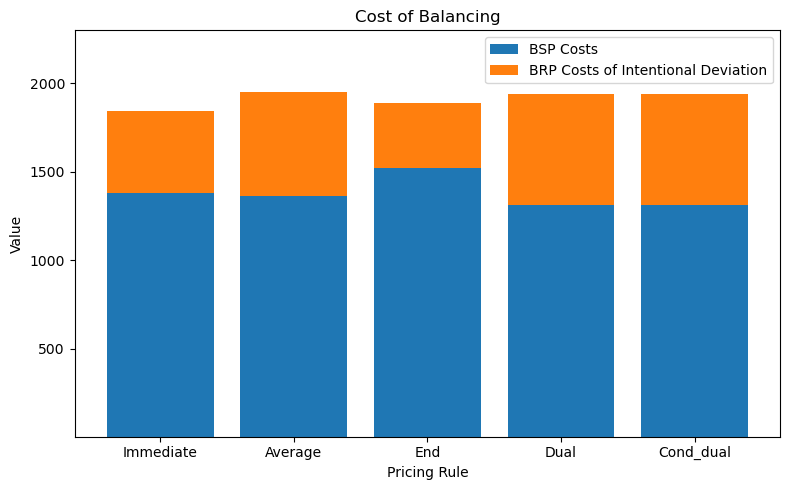

In [84]:
# --- 6.0) System Cost ---

fig0 = plt.figure(figsize=(8,5))

plt.bar(df['Rule'], df['E[γc²/2]'], label='BSP Costs')
plt.bar(df['Rule'], df['E[θx²/2]'], bottom=df['E[γc²/2]'], label='BRP Costs of Intentional Deviation')
plt.title('Cost of Balancing')
plt.legend()
plt.title('Cost of Balancing')
plt.xlabel('Pricing Rule')
plt.ylabel('Value')
plt.ylim(2, 2300)
plt.legend()

plt.tight_layout()
fig0.savefig("system_cost.png", dpi=300, bbox_inches="tight")
plt.show()

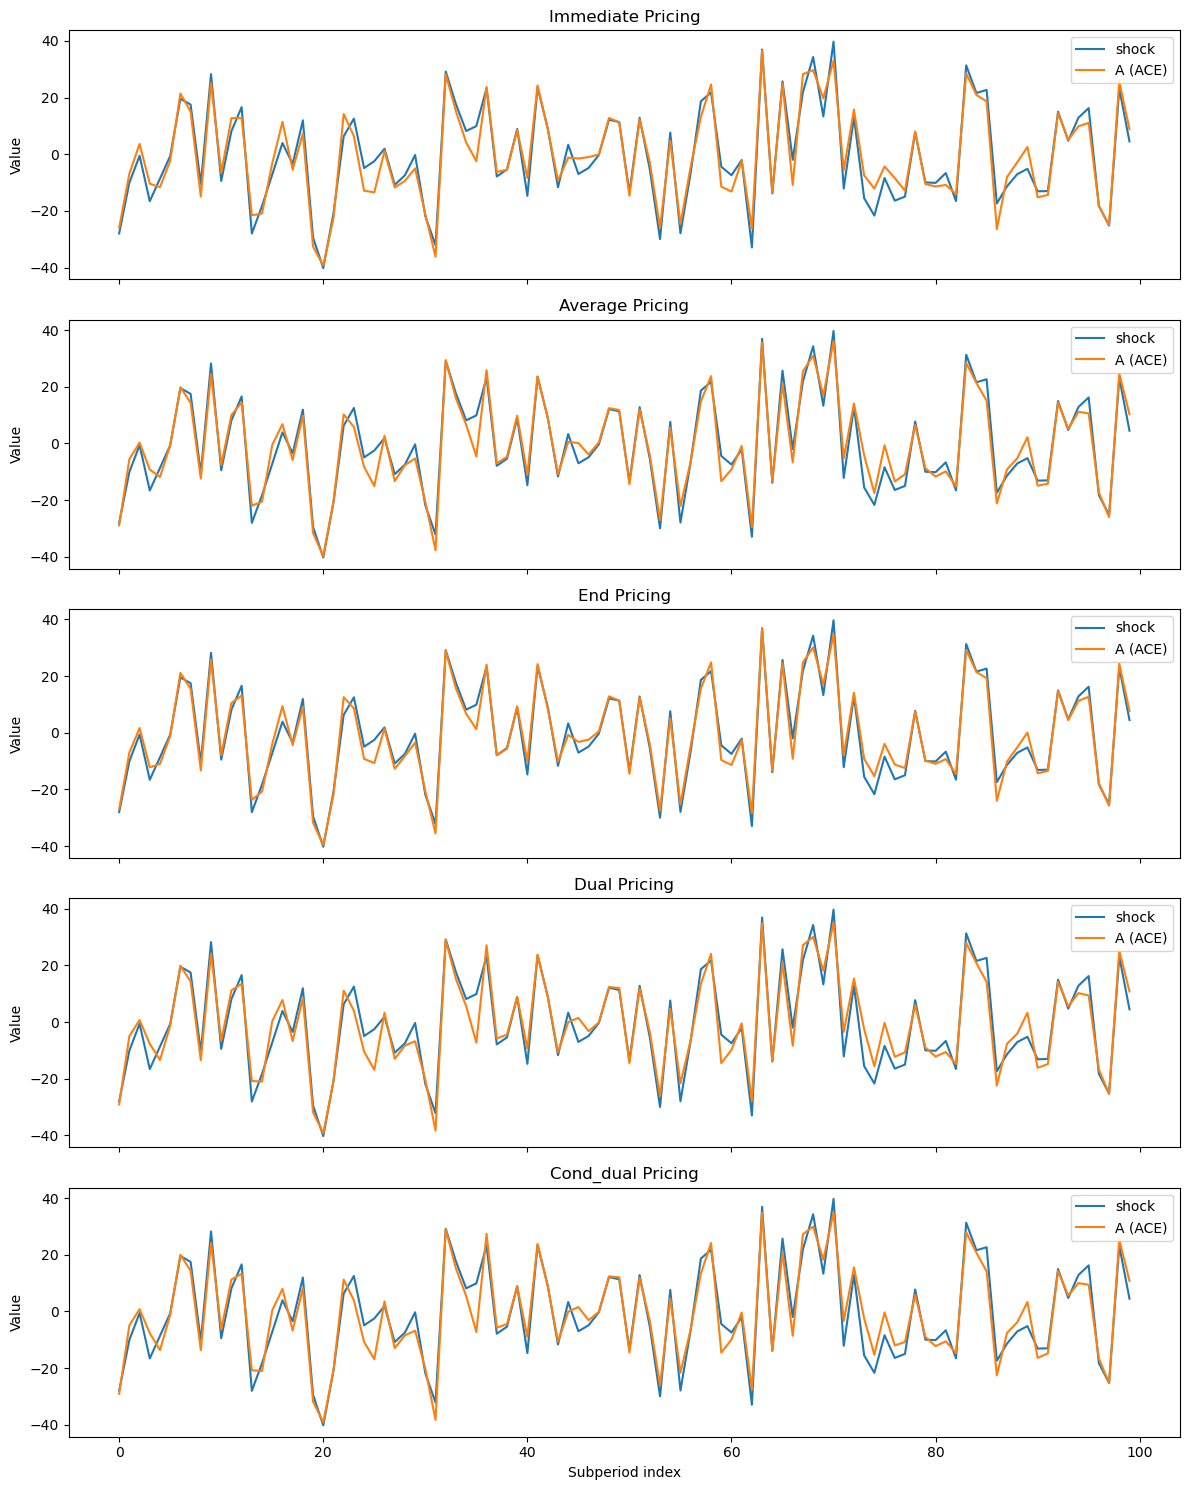

In [16]:
# --- 6.1) ACE and shock --- 
window = slice(100, 200)

n_rules = len(results)
fig1, axes = plt.subplots(n_rules, 1, figsize=(12, 3 * n_rules), sharex=True)

for ax, row in zip(axes, results):
    rule_name = row['Rule'].lower()
    alpha_star = row['α']
    beta_star  = row['β']
    scn = Scenario(PricingRules(rule_name))
    scn.input.alpha = alpha_star
    scn.input.beta = beta_star
    scn.input.eps = eps.copy()
    scn.output = sim_plus_prices(scn.input)

    A, x, c, mu, p = scn.output.a, scn.output.x, scn.output.c, scn.output.mu, scn.output.p

    ax.plot(eps.flatten()[window], label='shock')
#    ax.plot(mu.flatten()[window], label='Unintentional Deviation')
    ax.plot(A.flatten()[window], label='A (ACE)')
#    ax.plot(c.flatten()[window], label='Capacity')
#    ax.plot(x.flatten()[window], label='BRP intentional imbalance')
#    ax.plot((-x-c).flatten()[window], label='Active + Passive Balancing')
    ax.set_title(f'{rule_name.capitalize()} Pricing')
    ax.legend(loc='upper right')
    ax.set_ylabel('Value')

axes[-1].set_xlabel('Subperiod index')
plt.tight_layout()
fig1.savefig("balancingpower.png", dpi=300, bbox_inches="tight")
plt.show()

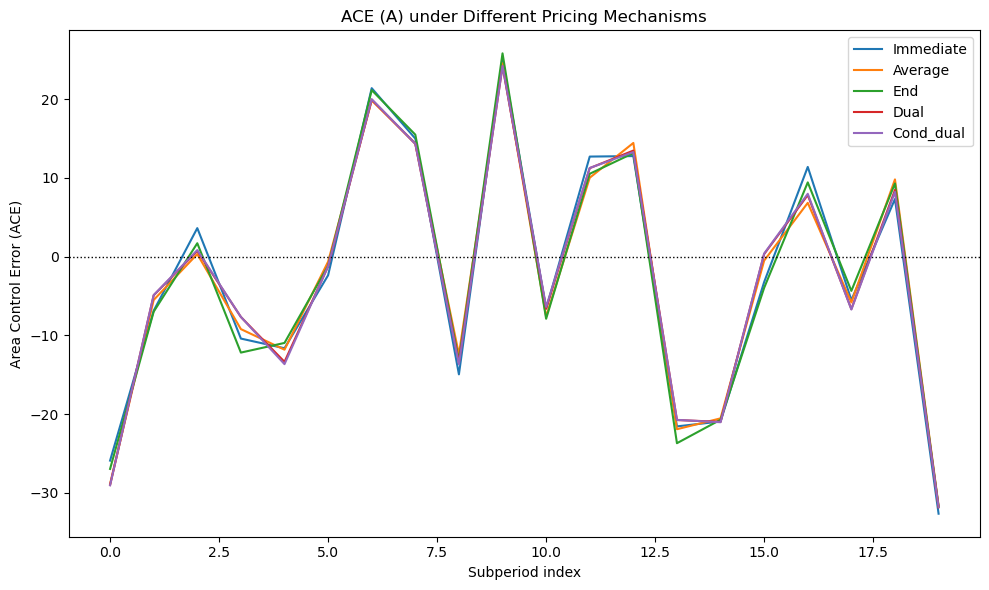

In [17]:
# --- 6.2) ACE ---
window = slice(100, 120)

fig2 = plt.figure(figsize=(10, 6))

for rule in rules:
    rule_name = rule.value.capitalize()
    row = next(r for r in results if r['Rule'] == rule_name)
    
    alpha_star = row['α']
    beta_star = row['β']
    
    scn = Scenario(rule)
    scn.input.alpha = alpha_star
    scn.input.beta  = beta_star
    scn.input.eps   = eps.copy()
    scn.output = sim_plus_prices(scn.input)
    
    A = scn.output.a

    plt.plot(
        A.flatten()[window],
        label=rule_name
    )

plt.title('ACE (A) under Different Pricing Mechanisms')
plt.xlabel('Subperiod index')
plt.ylabel('Area Control Error (ACE)')
plt.axhline(y=0, color='black', linestyle=':', linewidth=1)
plt.legend()
plt.tight_layout()
fig2.savefig("comparisonACE.png", dpi=300, bbox_inches="tight")
plt.show()

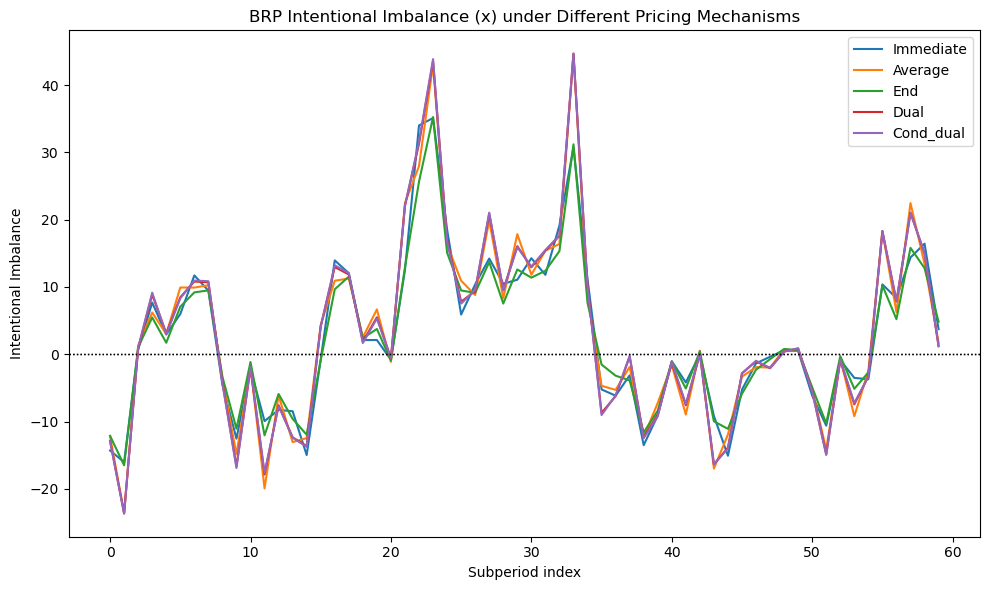

In [18]:
# --- 6.3) BRP imbalance ---
window = slice(100, 160)

fig3 = plt.figure(figsize=(10, 6))

for rule in rules:
    rule_name = rule.value.capitalize()
    row = next(r for r in results if r['Rule'] == rule_name)
    
    alpha_star = row['α']
    beta_star = row['β']

    scn = Scenario(rule)
    scn.input.alpha = alpha_star
    scn.input.beta  = beta_star
    scn.input.eps   = eps.copy()
    scn.output = sim_plus_prices(scn.input)
    
    x = scn.output.x

    plt.plot(
        x.flatten()[window],
        label=rule_name
    )
    
plt.axhline(y=0, color='black', linestyle=':', linewidth=1)

plt.title('BRP Intentional Imbalance (x) under Different Pricing Mechanisms')
plt.xlabel('Subperiod index')
plt.ylabel('Intentional Imbalance')
plt.axhline(y=0, color='black', linestyle=':', linewidth=1)
plt.legend()
plt.tight_layout()
fig3.savefig("comparisonBRP.png", dpi=300, bbox_inches="tight")
plt.show()


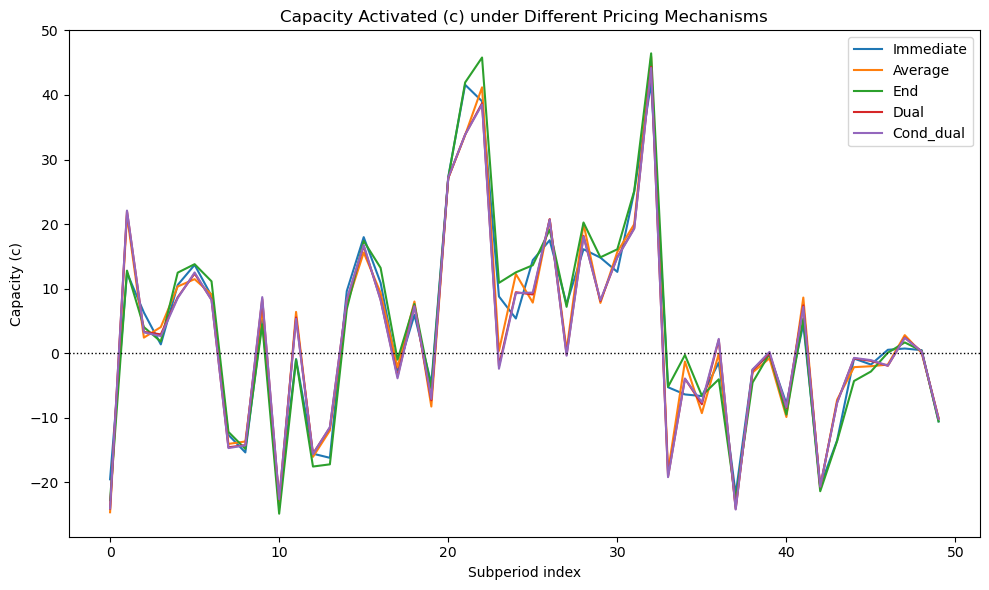

In [19]:
# --- 6.4) Capacity activated (c) ---
window = slice(100, 150)

fig4 = plt.figure(figsize=(10, 6))

for rule in rules:
    rule_name = rule.value.capitalize()
    row = next(r for r in results if r['Rule'] == rule_name)

    alpha_star = row['α']
    beta_star = row['β']

    scn = Scenario(rule)
    scn.input.alpha = alpha_star
    scn.input.beta  = beta_star
    scn.input.eps   = eps.copy()
    scn.output = sim_plus_prices(scn.input)

    c = scn.output.c

    plt.plot(
        c.flatten()[window],
        label=rule_name
    )

plt.axhline(y=0, color='black', linestyle=':', linewidth=1)

plt.title('Capacity Activated (c) under Different Pricing Mechanisms')
plt.xlabel('Subperiod index')
plt.ylabel('Capacity (c)')
plt.legend()
plt.tight_layout()
fig4.savefig("comparisonC.png", dpi=300, bbox_inches="tight")
plt.show()


## Calibration

In [20]:
# --- Calibration targets from data ---
# added # to avoid running the calibration every time you run the code

#targets = {
#    'σ_c':   27.8262,
#    'ρ_c':   0.7366,
#    'σ_p':  179.4622,
#    'σ_xmu': 61.2721
#}

# --- Initial values ---
#gamma = 7
#theta = 5
#sigma = 15
#rho = 0.85
#λ = 0.1           # learning rate
#N_iter = 10       # calibration iterations

# --- Calibration loop ---
#for step in range(N_iter):
#    print(f"\nStep {step+1} ------------------")
    
    # Simulate scenario for Cond_Dual
#    scn = Scenario(PricingRules.cond_dual)
#    scn.input.alpha = alpha_init.copy()
#    scn.input.beta = beta_init.copy()
#    np.random.seed(12345)
#    scn.input.eps = np.random.normal(0, sigma, (Tmax, 2))

#    c = scn.output.c
#    x = scn.output.x
#    mu = scn.output.mu
#    p = scn.output.p
    
#    c_isp = c.sum(axis=1)
#    xmu_isp = (x + mu).sum(axis=1)
#    p_isp = p.mean(axis=1)

#    σ_c_m = np.std(c_isp)
#    ρ_c_m = np.corrcoef(c_isp[:-1], c_isp[1:])[0, 1]
#    σ_p_m = np.std(p_isp)
#    σ_xmu_m = np.std(xmu_isp)

#    print(f"Model σ_c: {σ_c_m:.4f}, ρ_c: {ρ_c_m:.4f}, σ_p: {σ_p_m:.4f}, σ_x+μ: {σ_xmu_m:.4f}")
#    print(f"Current Params σ_ε: {sigma:.4f}, ρ_μ: {rho:.4f}, γ: {gamma:.4f}, θ: {theta:.4f}")

#    sigma_new = sigma * (targets['σ_c'] / σ_c_m) ** λ
#    rho_logit = np.log(rho / (1 - rho))
#    rho_target_logit = np.log(targets['ρ_c'] / (1 - targets['ρ_c']))
#    rho_logit_new = rho_logit + λ * (rho_target_logit - np.log(ρ_c_m / (1 - ρ_c_m)))
#    rho_new = np.exp(rho_logit_new) / (1 + np.exp(rho_logit_new))

#    gamma_new = gamma * (targets['σ_p'] / σ_p_m) ** λ
#    theta_new = theta * (σ_xmu_m / targets['σ_xmu']) ** λ * (gamma_new / gamma)

#    sigma = np.clip(sigma_new, 0.1, 20)
#    rho   = np.clip(rho_new,   0.01, 0.85)    # clipping rho avoid overflowing issue, but at the same time hindering the possibility of finding a precise estimation of the values of rho_c 
#    gamma = np.clip(gamma_new, 0.1, 20)
#    theta = np.clip(theta_new, 0.1, 20)

#    print(f"Updated Params σ_ε: {sigma:.4f}, ρ_μ: {rho:.4f}, γ: {gamma:.4f}, θ: {theta:.4f}")

## Graphs Calibration

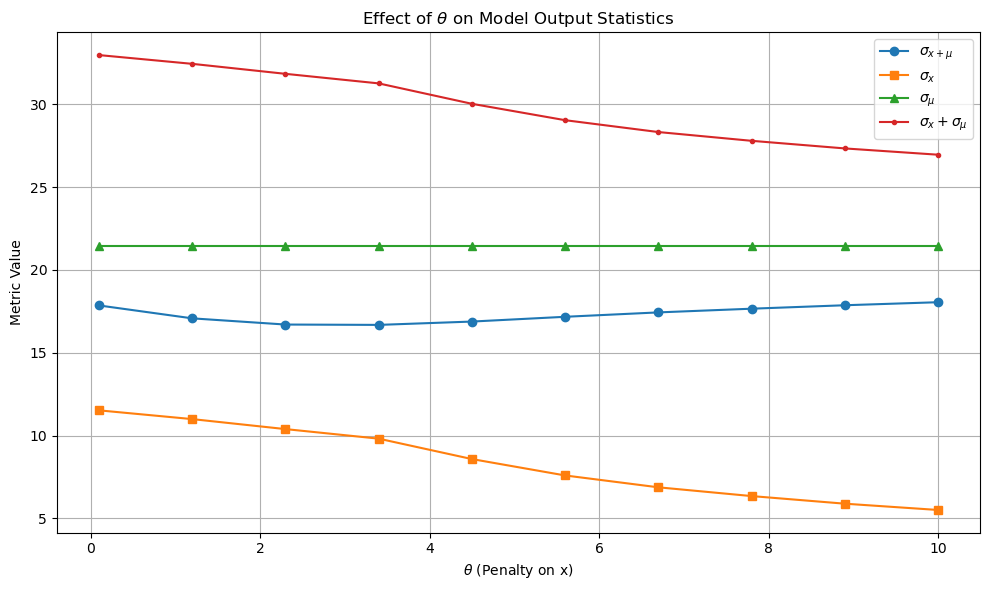

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# --- Locked calibrated parameters ---
gamma = 4
sigma = 12
rho = 0.85
Tmax=1000
theta_values = np.linspace(0.1, 10, 10)

# --- Seeded ε for consistency across θ iterations ---
np.random.seed(1234)
eps_static = np.random.normal(0, sigma, (Tmax, 2))

# --- Lists to store each metric ---
σ_xmu_list = []
σ_x_list   = []
σ_mu_list   = []
sigma_xmu_list =[]

for th in theta_values:
    theta = th
    try:
        scn = Scenario(PricingRules.cond_dual)
        scn.input.alpha = alpha_init.copy()
        scn.input.beta = beta_init.copy()
        scn.input.eps = eps_static.copy()

        scn = find_equilibrium(scn, Niter=10, lmbda=0.2, tolerance=1e-6)

        # Extract outputs
        c = scn.output.c
        x = scn.output.x
        mu = scn.output.mu
        p = scn.output.p

        # Compute time series (sum over directions)

        # Store metrics
        σ_xmu_list.append(np.std(x+mu))
        σ_x_list.append(np.std(x))
        σ_mu_list.append(np.std(mu))
        sigma_xmu_list.append(np.std(x)+np.std(mu))

    except Exception as e:
        print(f"⚠️ θ={th:.2f} caused error: {e}")
        σ_xmu_list.append(np.nan)
        σ_x_list.append(np.nan)
        σ_mu_list.append(np.nan)
    
# --- Plotting ---
fig_opt1=plt.figure(figsize=(10, 6))

plt.plot(theta_values, σ_xmu_list, label=r"$\sigma_{x+\mu}$", marker='o')
plt.plot(theta_values, σ_x_list,   label=r"$\sigma_x$", marker='s')
plt.plot(theta_values, σ_mu_list,   label=r"$\sigma_{\mu}$", marker='^')
plt.plot(theta_values, sigma_xmu_list,   label=r"$\sigma_x+\sigma_{\mu}$", marker='.')

plt.xlabel(r"$\theta$ (Penalty on x)")
plt.ylabel("Metric Value")
plt.title(r"Effect of $\theta$ on Model Output Statistics")
plt.grid(True)
plt.legend()
plt.tight_layout()
fig_opt1.savefig("theta on sigma.png", dpi=300, bbox_inches="tight")
plt.show()

/tmp/ipykernel_402/2237316944.py:6: RuntimeWarning: overflow encountered in square
  return (np.sum(a**2)/(2*Tmax))**0.5
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/tmp/ipykernel_402/2078564100.py:19: RuntimeWarning: overflow encountered in scalar add
  c[i, 0] = -rho * a[i-1, 1] + alpha[0]*c[i-1, 1] + alpha[2]*c[i-1, 0] #eq3
/tmp/ipykernel_402/2078564100.py:26: RuntimeWarning: invalid value encountered in scalar add
  a[i, 1] = c[i, 1] + x[i, 1] + mu[i, 1] #eq1
/tmp/ipykernel_402/2078564100.py:20: RuntimeWarning: invalid value encountered in scalar add
  x[i, 0] = beta[0]*c[i-1, 1] + beta[2]*c[i-1, 0] #eq5
/tmp/ipykernel_402/3096286930.py:29: RuntimeWarning: overflow encountered in multiply
  price_max = gamma * np.maximum(c[:,0], c[:,1])  #only have two possible type of price --> max or min
/tmp/ipykernel_402/3096286930.py:30: RuntimeWarning: overflow encountered in multiply
  price_

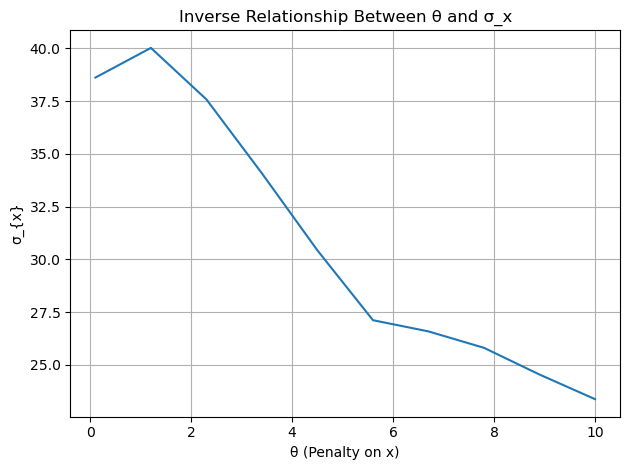

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# --- Locked calibrated parameters ---
gamma = 9.0490
sigma = 17.8482
rho = 0.85
theta_values = np.linspace(0.1, 10, 10)

# --- Seeded epsilon for deterministic calibration ---
np.random.seed(1234)
eps_static = np.random.normal(0, sigma, (Tmax, 2))

sigma_x_list = []

for th in theta_values:
    theta = th  # update global penalty on x

    try:
        scn = Scenario(PricingRules.cond_dual)
        scn.input.alpha = alpha_init.copy()
        scn.input.beta = beta_init.copy()
        scn.input.eps = eps_static.copy()

        # override simulate or add this inside find_equilibrium if needed
        def safe_sim_plus_prices(inputs):
            outputs = sim_plus_prices(inputs)

            # --- Safeguard overflow ---
            outputs.c = np.clip(outputs.c, -50, 50).astype(np.float32)
            outputs.x = np.clip(outputs.x, -100, 100).astype(np.float32)
            outputs.mu = np.clip(outputs.mu, -100, 100).astype(np.float32)
            return outputs

        scn = find_equilibrium(scn, Niter=10, lmbda=0.2, tolerance=1e-6)
        scn.output = safe_sim_plus_prices(scn.input)

        x = scn.output.x
        mu = scn.output.mu

        sigma_x_list.append(np.std(x.sum(axis=1)))

    except Exception as e:
        print(f"⚠️ θ={th:.2f} caused error: {e}")
        sigma_x_list.append(np.nan)

# --- Plot Result ---
valid_mask = ~np.isnan(sigma_x_list)
plt.plot(theta_values[valid_mask], sigma_x_list)
plt.xlabel("θ (Penalty on x)")
plt.ylabel("σ_{x}")
plt.title("Inverse Relationship Between θ and σ_x")
plt.grid(True)
plt.tight_layout()
plt.show()

## sarebbe carino da fare con tutti i parametri --> daje Roma

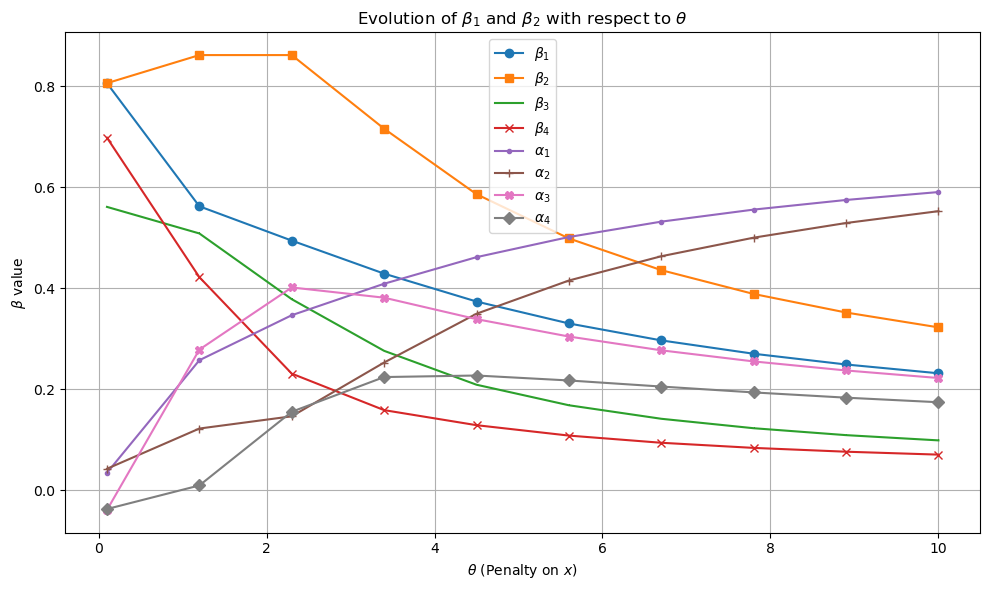

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# --- Fixed global parameters ---
gamma = 4
sigma = 12
rho = 0.85
theta_values = np.linspace(0.1, 10, 10)

# --- Fixed ε across simulations for consistency ---
np.random.seed(1234)
eps_static = np.random.normal(0, sigma, (Tmax, 2))

# --- Store β1 and β2 for each θ ---
beta1_list = []
beta2_list = []
beta3_list =[]
beta4_list =[]
alpha1_list =[]
alpha2_list =[]
alpha3_list = []
alpha4_list = []

for th in theta_values:
    theta = th
    try:
        scn = Scenario(PricingRules.average)
        scn.input.alpha = alpha_init.copy()
        scn.input.beta = beta_init.copy()
        scn.input.eps = eps_static.copy()

        # Solve for equilibrium with updated θ
        scn = find_equilibrium(scn, Niter=10, lmbda=0.2, tolerance=1e-6)

        β = scn.input.beta
        beta1_list.append(β[0])  # β1 = weight on c[i,0] → x[i,1]
        beta2_list.append(β[1])  # β2 = weight on c[i-1,0] → x[i,0]
        beta3_list.append(β[2])
        beta4_list.append(β[3])
        alpha = scn.input.alpha
        alpha1_list.append(alpha[0])  # β1 = weight on c[i,0] → x[i,1]
        alpha2_list.append(alpha[1])  # β2 = weight on c[i-1,0] → x[i,0]
        alpha3_list.append(alpha[2])
        alpha4_list.append(alpha[3])

    except Exception as e:
        print(f"⚠️ θ={th:.2f} caused error: {e}")
        beta1_list.append(np.nan)
        beta2_list.append(np.nan)

# --- Plotting ---
plt.figure(figsize=(10, 6))
plt.plot(theta_values, beta1_list, marker='o', label=r"$\beta_1$")
plt.plot(theta_values, beta2_list, marker='s', label=r"$\beta_2$")
plt.plot(theta_values, beta3_list, marker=',', label=r"$\beta_3$")
plt.plot(theta_values, beta4_list, marker='x', label=r"$\beta_4$")

plt.plot(theta_values, alpha1_list, marker='.', label=r"$\alpha_1$")
plt.plot(theta_values, alpha2_list, marker='+', label=r"$\alpha_2$")
plt.plot(theta_values, alpha3_list, marker='X', label=r"$\alpha_3$")
plt.plot(theta_values, alpha4_list, marker='D', label=r"$\alpha_4$")

plt.xlabel(r"$\theta$ (Penalty on $x$)")
plt.ylabel(r"$\beta$ value")
plt.title(r"Evolution of $\beta_1$ and $\beta_2$ with respect to $\theta$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [24]:
import numpy as np
import matplotlib.pyplot as plt

# --- Locked parameters ---
sigma = 12
rho = 0.85
theta_values = np.linspace(0.1, 10, 10)
gamma_values = np.linspace(0.1, 10, 10)

# --- Seeded epsilon for deterministic output ---
np.random.seed(1234)
eps_static = np.random.normal(0, sigma, (Tmax, 2))

sigma_xmu_theta = []
sigma_x_theta   = []
sigma_mu_theta   = []
sigma_c_theta =[]

sigma_x_gamma = []
sigma_mu_gamma = []
sigma_xmu_gamma = []
sigma_c_gamma = []

# --- Helper for overflow-safe simulation ---
def safe_sim_plus_prices(inputs):
    outputs = sim_plus_prices(inputs)
    outputs.c = np.clip(outputs.c, -50, 50).astype(np.float32)
    outputs.x = np.clip(outputs.x, -100, 100).astype(np.float32)
    outputs.mu = np.clip(outputs.mu, -100, 100).astype(np.float32)
    return outputs

# --- Sweep over θ ---
gamma = 4 # fixed gamma
for th in theta_values:
    theta = th
    try:
        scn = Scenario(PricingRules.average)
        scn.input.alpha = alpha_init.copy()
        scn.input.beta = beta_init.copy()
        scn.input.eps = eps_static.copy()

        scn = find_equilibrium(scn, Niter=10, lmbda=0.2, tolerance=1e-6)
        scn.output = safe_sim_plus_prices(scn.input)

        sigma_x_theta.append(np.std((scn.output.x)))
        sigma_xmu_theta.append(np.std(((scn.output.x)+(scn.output.mu))))
        sigma_mu_theta.append(np.std((scn.output.mu)))
        sigma_c_theta.append(np.std((scn.output.c)))

    except Exception as e:
        print(f"⚠️ θ={th:.2f} failed: {e}")
        sigma_x_theta.append(np.nan)

# --- Sweep over γ ---
theta = 4  # fixed theta
for g in gamma_values:
    gamma = g
    try:
        scn = Scenario(PricingRules.cond_dual)
        scn.input.alpha = alpha_init.copy()
        scn.input.beta = beta_init.copy()
        scn.input.eps = eps_static.copy()

        scn = find_equilibrium(scn, Niter=10, lmbda=0.2, tolerance=1e-6)
        scn.output = safe_sim_plus_prices(scn.input)

        sigma_x_gamma.append(np.std((scn.output.x)))
        sigma_mu_gamma.append(np.std((scn.output.mu)))
        sigma_c_gamma.append(np.std((scn.output.c)))
        sigma_xmu_gamma.append(np.std(((scn.output.x)+(scn.output.mu))))

    except Exception as e:
        print(f"⚠️ γ={g:.2f} failed: {e}")
        sigma_x_gamma.append(np.nan)

# --- Plotting Both Comparisons ---
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# θ subplot
valid_mask_theta = ~np.isnan(sigma_x_theta)
axs[0].plot(theta_values[valid_mask_theta], np.array(sigma_x_theta)[valid_mask_theta], marker='o', label=r"$\sigma_x \theta$")
axs[0].plot(theta_values[valid_mask_theta], np.array(sigma_xmu_theta)[valid_mask_theta], marker='s', label=r"$\sigma_(x+\mu) \theta$")
axs[0].plot(theta_values[valid_mask_theta], np.array(sigma_mu_theta)[valid_mask_theta], marker=',', label=r"$\sigma_(\mu) \theta$")
axs[0].plot(theta_values[valid_mask_theta], np.array(sigma_c_theta)[valid_mask_theta], marker='x', label=r"$\sigma_c \theta$")

axs[0].set_xlabel(r"$\theta$ (Penalty on $x$)")
axs[0].set_ylabel(r"$\sigma_x$")
axs[0].set_title("Impact of θ on σₓ")
plt.tight_layout()
axs[0].grid(True)

# γ subplot
valid_mask_gamma = ~np.isnan(sigma_x_gamma)
axs[1].plot(gamma_values[valid_mask_gamma], np.array(sigma_x_gamma)[valid_mask_gamma], marker='s', label=r"$\sigma_x \gamma$")
axs[1].plot(gamma_values[valid_mask_gamma], np.array(sigma_mu_gamma)[valid_mask_gamma], marker='P', label=r"$\sigma_\mu \gamma$")
axs[1].plot(theta_values[valid_mask_gamma], np.array(sigma_xmu_gamma)[valid_mask_gamma], marker='.', label=r"$\sigma_(x+\mu) \gamma$")
axs[1].plot(gamma_values[valid_mask_gamma], np.array(sigma_c_gamma)[valid_mask_gamma], marker='+', label=r"$\sigma_c \gamma$")

axs[1].set_xlabel(r"$\gamma$ (Price sensitivity)")
axs[1].set_ylabel(r"$\sigma_x$")
axs[1].set_title("Impact of γ on σₓ")
axs[1].grid(True)

plt.suptitle("Sensitivity of $\\sigma_x$ to θ and γ", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
theta_values = np.linspace(0.1, 10, 8)
gamma_values = np.linspace(0.1, 20, 8)

# Fixed global values
sigma = 10
rho = 0.85

np.random.seed(1234)
eps_static = np.random.normal(0, sigma, (Tmax, 2))

pricing_rules = list(PricingRules)
rule_names = {
    PricingRules.immediate: "Immediate",
    PricingRules.average: "Average",
    PricingRules.end: "End",
    PricingRules.dual: "Dual",
    PricingRules.cond_dual: "Cond_Dual"
}

# --- Results containers ---
results = {
    "theta": {rule: {"σ_x": [], "σ_xmu": [], "σ_c": []} for rule in pricing_rules},
    "gamma": {rule: {"σ_x": [], "σ_xmu": [], "σ_c": []} for rule in pricing_rules}
}

# --- Simulation runner ---
def run_sim(rule, gamma_val, theta_val):
    global gamma, theta
    gamma = gamma_val
    theta = theta_val

    scn = Scenario(rule)
    scn.input.alpha = alpha_init.copy()
    scn.input.beta = beta_init.copy()
    scn.input.eps = eps_static.copy()

    scn = find_equilibrium(scn, Niter=10, lmbda=0.2, tolerance=1e-6)
    scn.output = sim_plus_prices(scn.input)

    x = scn.output.x
    mu = scn.output.mu
    c = scn.output.c

    σx = np.std(x.sum(axis=1))
    σxmu = np.std((x + mu).sum(axis=1))
    σc = np.std(c.sum(axis=1))
    return σx, σxmu, σc

# --- θ sweep ---
for rule in pricing_rules:
    for th in theta_values:
        try:
            σx, σxmu, σc = run_sim(rule, gamma_val=6, theta_val=th)
        except Exception as e:
            print(f"⚠️ θ={th:.2f} {rule.name} failed: {e}")
            σx, σxmu, σc = np.nan, np.nan, np.nan
        results["theta"][rule]["σ_x"].append(σx)
        results["theta"][rule]["σ_xmu"].append(σxmu)
        results["theta"][rule]["σ_c"].append(σc)

# --- γ sweep ---
for rule in pricing_rules:
    for gm in gamma_values:
        try:
            σx, σxmu, σc = run_sim(rule, gamma_val=gm, theta_val=4.0)
        except Exception as e:
            print(f"⚠️ γ={gm:.2f} {rule.name} failed: {e}")
            σx, σxmu, σc = np.nan, np.nan, np.nan
        results["gamma"][rule]["σ_x"].append(σx)
        results["gamma"][rule]["σ_xmu"].append(σxmu)
        results["gamma"][rule]["σ_c"].append(σc)

In [ ]:
for rule in pricing_rules:
    fig, axs = plt.subplots(1, 2, figsize=(14, 4))
    name = rule_names[rule]

    axs[0].plot(theta_values, results["theta"][rule]["σ_x"], marker='o', label=r"$\sigma_x$")
    axs[0].plot(theta_values, results["theta"][rule]["σ_xmu"], marker='x', label=r"$\sigma_{x+\mu}$")
    axs[0].set_title(f"{name} – vs $\\theta$")
    axs[0].set_xlabel(r"$\theta$")
    axs[0].set_ylabel(r"$\sigma$")
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(gamma_values, results["gamma"][rule]["σ_x"], marker='s', label=r"$\sigma_x$")
    axs[1].plot(gamma_values, results["gamma"][rule]["σ_xmu"], marker='D', label=r"$\sigma_{x+\mu}$")
    axs[1].set_title(f"{name} – vs $\\gamma$")
    axs[1].set_xlabel(r"$\gamma$")
    axs[1].set_ylabel(r"$\sigma$")
    axs[1].legend()
    axs[1].grid(True)

    plt.suptitle(f"{name} Pricing – Sensitivity to $\\theta$ and $\\gamma$", fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
# --- Plotting ---
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# θ vs σ_x
for rule in pricing_rules:
    axs[0, 0].plot(theta_values, results["theta"][rule]["σ_x"], marker='o', label=rule_names[rule])
axs[0, 0].set_title(r"$\sigma_x$ vs $\theta$")
axs[0, 0].set_xlabel(r"$\theta$")
axs[0, 0].set_ylabel(r"$\sigma_x$")
axs[0, 0].legend()
axs[0, 0].grid(True)

# θ vs σ_x+μ
for rule in pricing_rules:
    axs[0, 1].plot(theta_values, results["theta"][rule]["σ_xmu"], marker='o', label=rule_names[rule])
axs[0, 1].set_title(r"$\sigma_{x+\mu}$ vs $\theta$")
axs[0, 1].set_xlabel(r"$\theta$")
axs[0, 1].set_ylabel(r"$\sigma_{x+\mu}$")
axs[0, 1].legend()
axs[0, 1].grid(True)

# γ vs σ_x
for rule in pricing_rules:
    axs[1, 0].plot(gamma_values, results["gamma"][rule]["σ_x"], marker='s', label=rule_names[rule])
axs[1, 0].set_title(r"$\sigma_x$ vs $\gamma$")
axs[1, 0].set_xlabel(r"$\gamma$")
axs[1, 0].set_ylabel(r"$\sigma_x$")
axs[1, 0].legend()
axs[1, 0].grid(True)

# γ vs σ_x+μ
for rule in pricing_rules:
    axs[1, 1].plot(gamma_values, results["gamma"][rule]["σ_xmu"], marker='s', label=rule_names[rule])
axs[1, 1].set_title(r"$\sigma_{x+\mu}$ vs $\gamma$")
axs[1, 1].set_xlabel(r"$\gamma$")
axs[1, 1].set_ylabel(r"$\sigma_{x+\mu}$")
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.suptitle("Impact of $\\theta$ and $\\gamma$ on $\\sigma_x$ and $\\sigma_{x+\\mu}$", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# --- Plotting ---
fig_opt3, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot vs θ
for rule in pricing_rules:
    name = rule_names[rule]
    axs[0].plot(theta_values, results["theta"][rule]["σ_x"],     marker='o', label=f"{name} – σₓ", linestyle='-')
    axs[0].plot(theta_values, results["theta"][rule]["σ_xmu"],   marker='s', label=f"{name} – σₓ₊μ", linestyle='--')
    axs[0].plot(theta_values, results["theta"][rule]["σ_c"],     marker='^', label=f"{name} – σ𝑐", linestyle=':')

axs[0].set_title(r"$\sigma_x$, $\sigma_{x+\mu}$, and $\sigma_c$ vs $\theta$")
axs[0].set_xlabel(r"$\theta$")
axs[0].set_ylabel(r"Standard deviation (σ)")
axs[0].grid(True)

# Plot vs γ
for rule in pricing_rules:
    name = rule_names[rule]
    axs[1].plot(gamma_values, results["gamma"][rule]["σ_x"],     marker='o', label=f"{name} – σₓ", linestyle='-')
    axs[1].plot(gamma_values, results["gamma"][rule]["σ_xmu"],   marker='s', label=f"{name} – σₓ₊μ", linestyle='--')
    axs[1].plot(gamma_values, results["gamma"][rule]["σ_c"],     marker='^', label=f"{name} – σ𝑐", linestyle=':')

axs[1].set_title(r"$\sigma_x$, $\sigma_{x+\mu}$, and $\sigma_c$ vs $\gamma$")
axs[1].set_xlabel(r"$\gamma$")
axs[1].grid(True)

# Legend outside
handles_0, labels_0 = axs[0].get_legend_handles_labels()
handles_1, labels_1 = axs[1].get_legend_handles_labels()
handles = handles_0 + handles_1
labels = labels_0 + labels_1
unique = dict(zip(labels, handles))
fig_opt3.legend(unique.values(), unique.keys(), loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.02))
fig.suptitle("Sensitivity of $\sigma_x$, $\sigma_{x+\mu}$, and $\sigma_c$ across Pricing Mechanisms", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 1])
fig_opt3.savefig("theta and gamma on sigma.png", dpi=300, bbox_inches="tight")
plt.show()
